### Importing the Libraries

In [1]:
from fastai.vision import *

### Moving the zip file from Drive

I uploaded the files in Google Drive, so I am transferring the zip file from my Google Drive to my workspace. I am using Google Collab and Google Drive(for data). Create a new folder `data` in your workplace which will have it's directory as `/content/data/`



In [3]:
shutil.copy("/content/drive/My Drive/Deeper Systems/train.rotfaces.zip","/content/data/")

'/content/data/train.rotfaces.zip'

In [4]:
%cd /content/data

/content/data


In [5]:
path = Path('/content/data')

In [6]:
shutil.copy("/content/drive/My Drive/Deeper Systems/test.rotfaces.zip","/content/data/")

'/content/data/test.rotfaces.zip'

In [7]:
path.ls()

[PosixPath('/content/data/test.rotfaces.zip'),
 PosixPath('/content/data/train.rotfaces.zip')]

In [8]:
%cd /content/data

/content/data


### Unzipping the Data

In [ ]:
!unzip test.rotfaces.zip
!unzip train.rotfaces.zip

In [10]:
path_train = path/'train'
path_test = path/'test'

In [11]:
df = pd.read_csv('train.truth.csv')

In [12]:
df

,fn,label
0,0-10049200_1891-09-16_1958.jpg,rotated_left
1,0-10110600_1985-09-17_2012.jpg,rotated_left
2,0-10126400_1964-07-07_2010.jpg,upright
3,0-1013900_1917-10-15_1960.jpg,rotated_right
4,0-10166400_1960-03-12_2008.jpg,upside_down
...,...,...
48891,89-9693789_1941-01-11_1973.jpg,upright
48892,89-9719989_1985-04-13_2004.jpg,rotated_left
48893,89-981289_1962-12-23_2009.jpg,rotated_left
48894,89-9921189_1983-11-25_2013.jpg,rotated_left


### Loading the Databunch

Loading the images using the fastai Data Block API, labeling from `df` and normalizing the images. Validation set taken here is `0.2` or `20%`

In [13]:
data = (ImageList.from_df(df, path ,folder = 'train')
        .split_by_rand_pct(0.2)
        .label_from_df()
        .add_test_folder('test')
        .transform()
        .databunch(bs = 64)
        .normalize(imagenet_stats))  

### Viewing the loaded Databunch

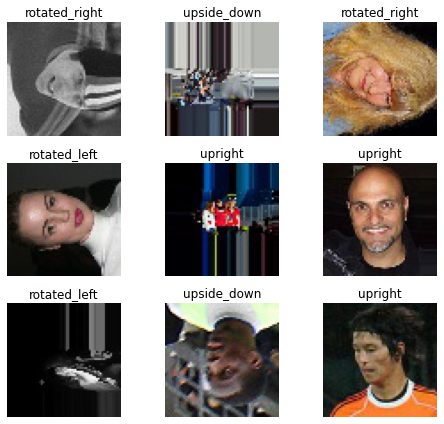

In [14]:
data.show_batch(rows=3, figsize=(7,6))

In [15]:
data.classes

['rotated_left', 'rotated_right', 'upright', 'upside_down']

In [16]:
len(data.classes), data.c

(4, 4)

### Creating a Model

Using convolutional neural networks using resnet34 pretrained architecture

In [17]:
learn = cnn_learner(data, models.resnet34, metrics= [error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 2.09E-02


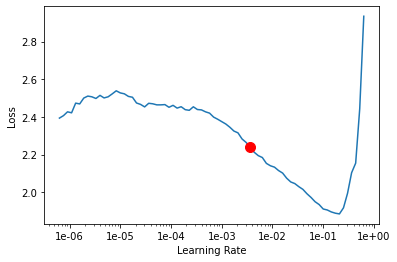

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(4, max_lr=1e-03)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.530118,0.330118,0.124041,0.875959,00:31
1,0.145728,0.100658,0.037325,0.962675,00:30
2,0.102628,0.070145,0.025054,0.974946,00:30
3,0.069205,0.068540,0.025565,0.974435,00:30


In [21]:
learn.save('stage-1')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

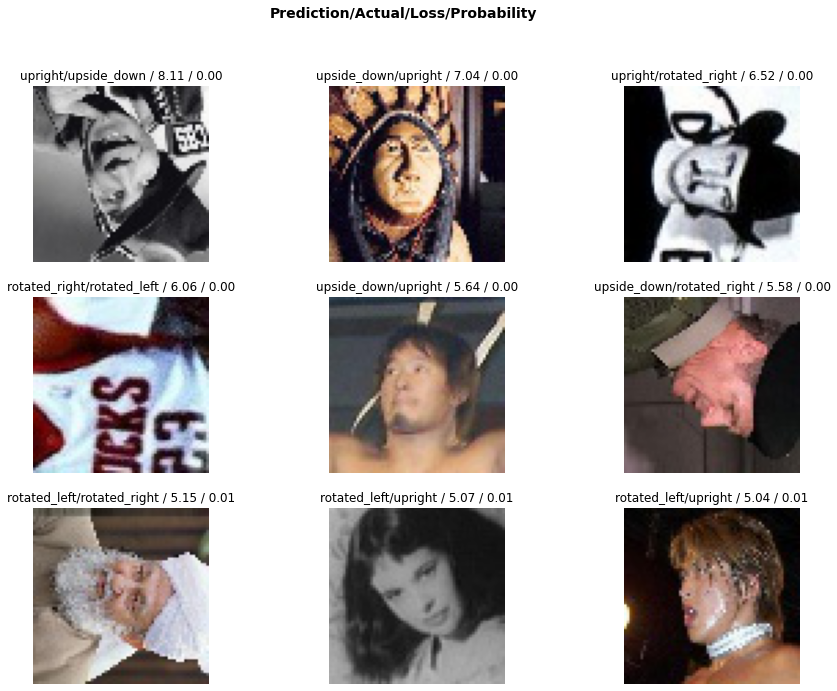

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

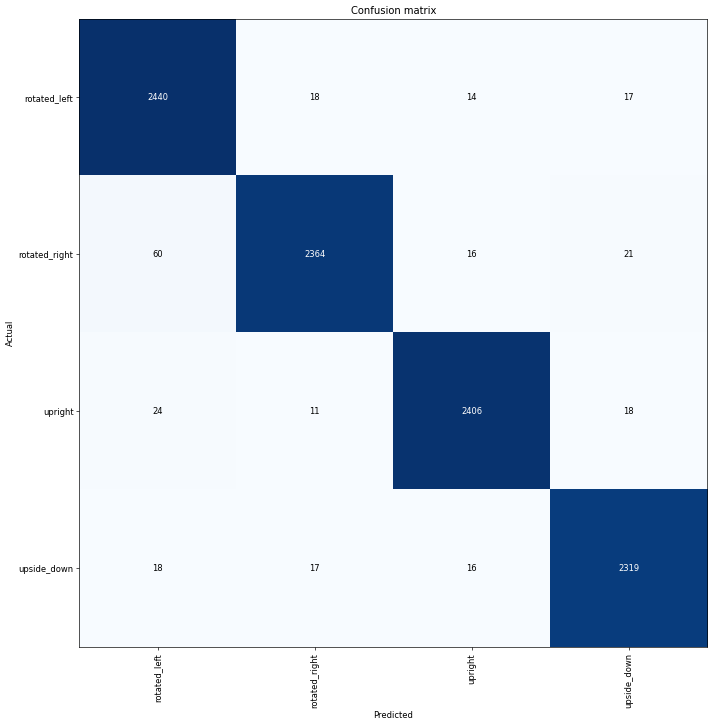

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
interp.most_confused(min_val=2)

[('rotated_right', 'rotated_left', 60),
 ('upright', 'rotated_left', 24),
 ('rotated_right', 'upside_down', 21),
 ('rotated_left', 'rotated_right', 18),
 ('upright', 'upside_down', 18),
 ('upside_down', 'rotated_left', 18),
 ('rotated_left', 'upside_down', 17),
 ('upside_down', 'rotated_right', 17),
 ('rotated_right', 'upright', 16),
 ('upside_down', 'upright', 16),
 ('rotated_left', 'upright', 14),
 ('upright', 'rotated_right', 11)]

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


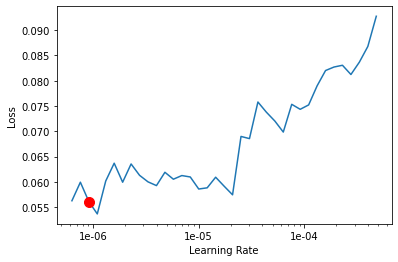

In [27]:
learn.lr_find()
learn.recorder.plot(suggestion= True)

Using callbacks to pick up the best model

In [28]:
from fastai.callbacks import *
callbacks = SaveModelCallback(learn,monitor="accuracy", mode="max", name="best_model")

In [29]:
learn.fit_one_cycle(10, slice(1e-7,1e-6), callbacks = [callbacks])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.066309,0.069438,0.024645,0.975355,00:36
1,0.064903,0.066983,0.023622,0.976378,00:36
2,0.067234,0.066537,0.023520,0.976480,00:36
3,0.066123,0.064430,0.022702,0.977298,00:36
4,0.068588,0.063789,0.023111,0.976889,00:36
5,0.068859,0.062174,0.021781,0.978219,00:36
6,0.055956,0.063535,0.023111,0.976889,00:35
7,0.055554,0.063485,0.022395,0.977605,00:35
8,0.057774,0.064800,0.023929,0.976071,00:35
9,0.054497,0.062862,0.022804,0.977196,00:35


Better model found at epoch 0 with accuracy value: 0.975355327129364.
Better model found at epoch 1 with accuracy value: 0.9763779640197754.
Better model found at epoch 2 with accuracy value: 0.9764801859855652.
Better model found at epoch 3 with accuracy value: 0.9772983193397522.
Better model found at epoch 5 with accuracy value: 0.9782186150550842.


In [30]:
path.ls()

[PosixPath('/content/data/test'),
 PosixPath('/content/data/models'),
 PosixPath('/content/data/test.rotfaces.zip'),
 PosixPath('/content/data/train.rotfaces.zip'),
 PosixPath('/content/data/train.truth.csv'),
 PosixPath('/content/data/train')]

In [ ]:
path_test.ls()

In [32]:
learn.save('final-model')

In [33]:
learn.export()

Opening an image and predict the label

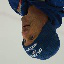

In [34]:
img = open_image(path_test/'95-3456495_1958-04-15_2014.jpg')
img

In [35]:
learn.predict(img)

(Category tensor(3),
 tensor(3),
 tensor([1.5138e-05, 8.1080e-06, 9.2940e-06, 9.9997e-01]))

In [36]:
data.classes

['rotated_left', 'rotated_right', 'upright', 'upside_down']

Tensor(3) is upside_down hence we predicted the correct label

Loading the Test data

In [37]:
test = ImageList.from_folder(path/'test')
len(test)

5361

In [38]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [39]:
thresh = 0.5
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [40]:
labelled_preds[:5]

['rotated_right', 'upside_down', 'upside_down', 'upright', 'rotated_left']

In [41]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]
fnames = [s + ".jpg" for s in fnames]

In [42]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

Writing the predicted labels to the test set in the given below CSV

In [43]:
df.to_csv('test.preds.csv', index = False)

To see all unique values of the labelled predictions. Since we set the threshold as 0.5, we are getting a few files which have no labels. If we keep a threshold below 0.5 then multile labels were appearing on images. So we kept an optimum of 0.5 as our threshold probability

In [44]:
set(labelled_preds)

{'', 'rotated_left', 'rotated_right', 'upright', 'upside_down'}

In [45]:
df

,image_name,tags
0,93-2122293_1957-04-24_2014.jpg,rotated_right
1,95-3456495_1958-04-15_2014.jpg,upside_down
2,90-36968290_1991-01-03_2013.jpg,upside_down
3,98-19618098_1983-02-07_2013.jpg,upright
4,90-29421390_1941-01-28_1978.jpg,rotated_left
...,...,...
5356,93-7893_1951-04-29_1990.jpg,upright
5357,90-31197790_1988-03-23_2013.jpg,rotated_left
5358,97-24396597_1984-05-01_2010.jpg,rotated_right
5359,98-3604398_1981-06-16_2012.jpg,upright


In [46]:
test

ImageList (5361 items)
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /content/data/test

In [47]:
data.classes

['rotated_left', 'rotated_right', 'upright', 'upside_down']

Writing a function `rotate_img` to rotate the image

In [48]:
from PIL import Image

def rotate_img(img, rt_degr):
    #img = Image.open(img_path)
    return img.rotate(rt_degr)



Creat a new folder `test_new` in your Google Colab environment to save rotated images

In [50]:
c = 0 
for i in test:
  if(df.tags[c] == 'rotated_right'):
    img_rt_90 = rotate_img(i, 90)
    img_rt_90.save('/content/test_new/'+df.image_name[c])
  if(df.tags[c] == 'rotated_left'):
    img_rt_270 = rotate_img(i, 270)
    img_rt_270.save('/content/test_new/'+df.image_name[c])
  if(df.tags[c] == 'upside_down'):
    img_rt_180 = rotate_img(i, 180)
    img_rt_180.save('/content/test_new/'+df.image_name[c])
  else:
    img_rt_0 = rotate_img(i, 0)
    img_rt_0.save('/content/test_new/'+df.image_name[c])
  c+=1
    



In [51]:
path_1 = Path('/content/test_new')

In [52]:
test_new = ImageList.from_folder(path_1)
len(test_new)

5361

In [54]:
learn = load_learner(path, test=test_new)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [55]:
thresh = 0.5
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [56]:
set(labelled_preds)

{'', 'rotated_left', 'rotated_right', 'upright', 'upside_down'}

In [57]:
df2 = pd.DataFrame(labelled_preds)

In [58]:
df2[0].value_counts()

upright          5195
                   61
rotated_right      45
upside_down        42
rotated_left       18
Name: 0, dtype: int64

In [60]:
print((5195/5361)*100,"% converted to Upright")

96.90356276814028 % converted to Upright


Most of the images (~97%) have been converted to upright images. 

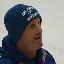

In [62]:
# Checking the same image that we checked before
img = open_image(path_1/'95-3456495_1958-04-15_2014.jpg')
img

It has been turned upright!!

Converting the updated test set into a zip file

In [68]:
shutil.make_archive('/content/'+'test_new', 'zip', '/content/test_new')

'/content/test_new.zip'